In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr4/bf527/nalluris/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
#unzip and read DEG matrix 
filename = "GSE75070_MCF7_shRUNX1_shNS_RNAseq_log2_foldchange.txt.gz"

de_genes = pd.read_csv(filename, compression='gzip', sep='\t')

#Read in annotated peaks file 
peaks_file = "annotated_peaks.txt"
peaks_df = pd.read_csv(peaks_file, sep='\t')

In [5]:
#Filter de genes based on original publication 
filtered_de_genes = de_genes[abs(de_genes['log2FoldChange']) > 1]
filtered_de_genes = filtered_de_genes[filtered_de_genes['padj'] < 0.01]

filtered_de_genes

,genename,transcript,log2FoldChange,padj
39,CYSRT1,NM_199001,-1.179227,6.910866e-04
48,SGOL1,"NM_001012409,NM_001012410,NM_001012411,NM_0010...",1.865109,7.048718e-16
50,MYCN,"NM_001293228,NM_001293231,NM_001293233",1.961676,9.265427e-05
66,INCENP,"NM_001040694,NM_020238",1.635607,3.296986e-14
80,VCAN,"NM_001126336,NM_001164097,NM_001164098,NM_004385",2.010163,1.561000e-06
...,...,...,...,...
15343,SCARNA12,NR_003010,-1.013360,2.225647e-08
15367,TM4SF1,NM_014220,-2.659629,1.184314e-13
15374,MAP1B,NM_005909,1.616677,3.342320e-09
15381,PAN2,"NM_001127460,NM_001166279,NM_014871",-1.394833,1.368096e-28


How many DE genes do you find? 

1153 genes

Do they match the numbers reported in the paper?

yes, the paper reports 1153 genes 

In [6]:
#merge de genes and peaks
merged_df = pd.merge(filtered_de_genes,peaks_df, how='left', left_on='genename', right_on='Gene Name')

In [57]:
bound = merged_df[merged_df['Gene Name'].notna()].drop_duplicates(subset=['Gene Name'])
unbound = merged_df[merged_df['Gene Name'].isna()].drop_duplicates(subset=['Gene Name'])
unbound = unbound[unbound.columns[0:4]]

In [58]:
#Create subsets for upregulated/downregulated and gene position 
filtered_de_up = filtered_de_genes[filtered_de_genes['log2FoldChange'] > 0]
filtered_de_down = filtered_de_genes[filtered_de_genes['log2FoldChange'] < 0]

bound_up_5kb = bound[(abs(bound['Distance to TSS']) <= 5000) & (bound['log2FoldChange'] > 0)]
bound_down_5kb = bound[(abs(bound['Distance to TSS']) <= 5000) & (bound['log2FoldChange'] < 0)]

unbound_up_5kb = filtered_de_up[~filtered_de_up['genename'].isin(bound_up_5kb['genename'])]
unbound_down_5kb = filtered_de_down[~filtered_de_down['genename'].isin(bound_down_5kb['genename'])]

bound_up_20kb = bound[(abs(bound['Distance to TSS']) <= 20000) & (bound['log2FoldChange'] > 0)]
bound_down_20kb = bound[(abs(bound['Distance to TSS']) <= 20000) & (bound['log2FoldChange'] < 0)]

unbound_up_20kb = filtered_de_up[~filtered_de_up['genename'].isin(bound_up_20kb['genename'])]
unbound_down_20kb = filtered_de_down[~filtered_de_down['genename'].isin(bound_down_20kb['genename'])]

bound_up_100kb = bound[(abs(bound['Distance to TSS']) <= 100000) & (bound['log2FoldChange'] > 0)]
bound_down_100kb = bound[(abs(bound['Distance to TSS']) <= 100000) & (bound['log2FoldChange'] < 0)]

unbound_up_100kb = filtered_de_up[~filtered_de_up['genename'].isin(bound_up_100kb['genename'])]
unbound_down_100kb = filtered_de_down[~filtered_de_down['genename'].isin(bound_down_100kb['genename'])]

In [65]:
#create df of counts 

data = [
    ("5kb up",len(unbound_up_5kb), len(bound_up_5kb)),
    ("5kb down",len(unbound_down_5kb), len(bound_down_5kb)),
    ("20kb up",len(unbound_up_20kb), len(bound_up_20kb)),
    ("20kb down",len(unbound_down_20kb), len(bound_down_20kb)),
    ("100kb up",len(unbound_up_100kb), len(bound_up_100kb)),
    ("100kb down",len(unbound_down_100kb), len(bound_down_100kb))
]

# Create a DataFrame from the list of tuples
peak_degene_counts= pd.DataFrame(data, columns=['id','unbound', 'bound'])

In [66]:
peak_degene_counts



,id,unbound,bound
0,5kb up,616,71
1,5kb down,411,55
2,20kb up,593,94
3,20kb down,398,68
4,100kb up,585,102
5,100kb down,389,77


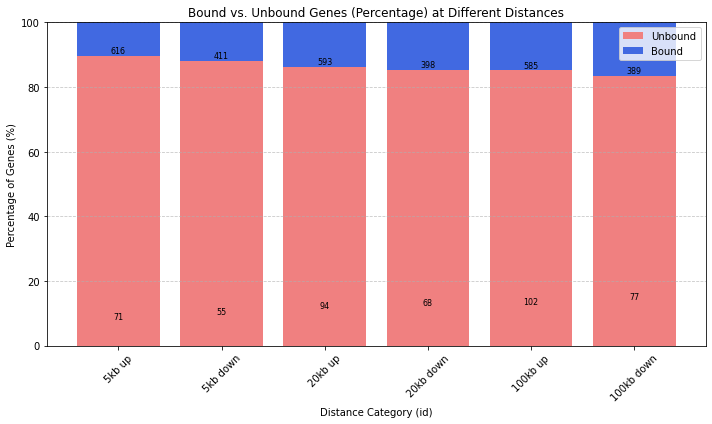

In [82]:
import matplotlib.pyplot as plt

# Direct access to columns within the DataFrame
distances = peak_degene_counts['id'].tolist()
unbound_counts = peak_degene_counts['unbound'].tolist()
bound_counts = peak_degene_counts['bound'].tolist()

# Calculate total counts for 100% stacking
total_counts = [a + b for a, b in zip(unbound_counts, bound_counts)]

# Normalize data for 100% stack (percentage of total count)
unbound_percentages = [count / total * 100 for count, total in zip(unbound_counts, total_counts)]
bound_percentages = [count / total * 100 for count, total in zip(bound_counts, total_counts)]

# Create the 100% stacked bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Create bars with normalized data
bars = plt.bar(distances, unbound_percentages, label='Unbound', color='lightcoral')
plt.bar(distances, bound_percentages, bottom=unbound_percentages, label='Bound', color='royalblue')

# Set labels and title (modify labels based on your data)
plt.xlabel('Distance Category (id)')  # Update label if 'id' doesn't reflect distance
plt.ylabel('Percentage of Genes (%)')
plt.title('Bound vs. Unbound Genes (Percentage) at Different Distances')

# Add legend
plt.legend()

# Display the chart
plt.xticks(distances, rotation=45)  # Set x-axis labels using distances
plt.ylim(0, 100)  # Set y-axis limits to 0-100 for percentages

# Add a grid (optional)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Text annotation for original counts (adjust y-positioning as needed)
y_offset = 0.1  # Adjust offset for label positioning
for i, (distance, unbound, bound) in enumerate(zip(distances, unbound_counts, bound_counts)):
  plt.text(i, unbound_percentages[i] + y_offset, f"{unbound}", ha='center', va='bottom', color='black', fontsize=8)
  plt.text(i, bound_percentages[i] + y_offset, f"{bound}", ha='center', va='top', color='black', fontsize=8)

plt.tight_layout()
plt.show()

